## Top 10 Hotspots  - Full, Monthly & Diurnal Climatology datasets

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
crs = {'init': 'epsg:4326'}

In [2]:
file_path = './LIS_VHRES/data_climatology/'
frd = Dataset(file_path + 'VHRFC.nc', 'r').variables['VHRFC_LIS_FRD'][:].data
masked_frd = np.ma.masked_where(frd == 0, frd) #fot the purposes of the first plot - black map


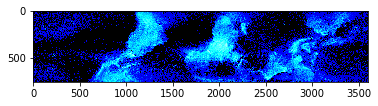

In [3]:
# Create a new colormap
cmap = LinearSegmentedColormap.from_list('',['mediumblue', "blue", "cyan", "white"])
#set the masked entries black
cmap.set_bad(color='black')
#check to see how it looks like (inverted)
plt.imshow(masked_frd, cmap=cmap, norm=LogNorm())

In [4]:
#find the place with the highest flash rate - reference spot

maximum  = int(round(np.amax(frd)))
lat = np.where(masked_frd == np.amax(frd))[0][0]
lon = np.where(masked_frd == np.amax(frd))[1][0]
real_lat = round(lat*0.1 - 38, 2)
real_lon = round(lon*0.1 - 180, 2)

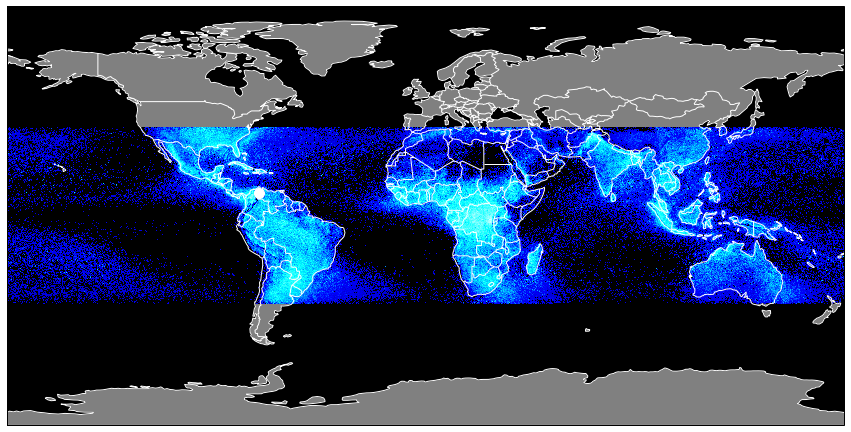

In [5]:
plt.close('all')
plt.figure(figsize=((15,10))) 

#plot the black map
img = plt.axes(projection=ccrs.PlateCarree())
img.set_extent([-180, 180, -90, 90])
img.coastlines(color='white')
img.add_feature(cfeature.LAND, facecolor='gray')
img.add_feature(cfeature.BORDERS, edgecolor='white')
img.add_feature(cfeature.OCEAN, facecolor='black')

#frd
lightnings = img.imshow(masked_frd, cmap=cmap, extent = [-180, 180, -38, 38],  norm=LogNorm())

#the place with the highest frd - reference spot
maxim = img.plot(real_lon, real_lat, 'wo', markersize=10) 

plt.savefig("Lightnings_full_climatology_black map_log scale.png")

plt.show()

In [6]:
#open the full climatology file in a geodataframe and filter it (keep >5 flashes)
df = pd.read_csv('./Full_Climatology.csv')
del df['Unnamed: 0']

gdf = gpd.GeoDataFrame(df, crs=crs, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf[gdf.VHRFC_LIS_FRD > 5]
del df
gdf

,Latitude,Longitude,VHRFC_LIS_FRD,geometry
25,-37.95,-143.25,11.821247,POINT (-143.25000 -37.95000)
64,-37.95,-70.25,10.962107,POINT (-70.25000 -37.95000)
102,-37.95,-64.85,5.436871,POINT (-64.85000 -37.95000)
104,-37.95,-64.65,5.594469,POINT (-64.65000 -37.95000)
113,-37.95,-63.65,6.793575,POINT (-63.65000 -37.95000)
...,...,...,...,...
1515491,37.95,131.75,5.861458,POINT (131.75000 37.95000)
1515502,37.95,136.25,5.857105,POINT (136.25000 37.95000)
1515515,37.95,139.35,7.016274,POINT (139.35000 37.95000)
1515563,37.95,154.25,5.855022,POINT (154.25000 37.95000)


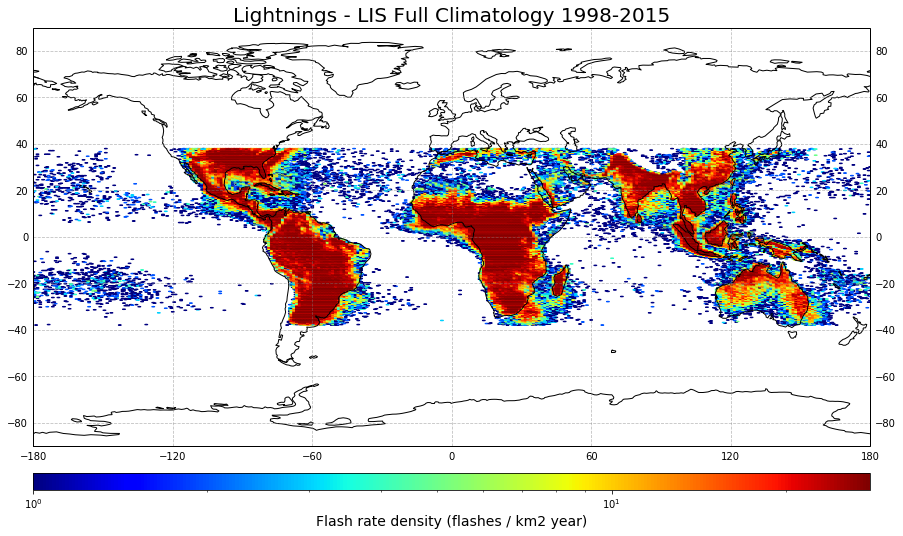

In [7]:
plt.close('all')

f = plt.figure(figsize=(15,10)) 

ax = f.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, alpha=0.5, color='grey', linestyle='--')
gl.xlabels_top=False

img = ax.hexbin(gdf.Longitude, gdf.Latitude, gridsize=300, bins='log', mincnt=1, cmap=plt.cm.jet)

cb = plt.colorbar(img, orientation='horizontal', pad=0.05, aspect = 50) 
cb.set_label('Flash rate density (flashes / km2 year)', fontsize=14) 
plt.title("Lightnings - LIS Full Climatology 1998-2015", fontsize = 20)

plt.savefig("Lightnings Full Climatology - hexbin map - threshold 5.png")

plt.show()

### Flash Hotspots

In [8]:
#We will work with a smaller sample, since we are only looking for the top 10 hotspots
gdf = gdf[gdf.VHRFC_LIS_FRD > 100]
gdf = gdf.sort_values(by='VHRFC_LIS_FRD', ascending=False)

In [9]:
cities_file = './cities_data/ne_10m_populated_places_simple.shp'
cities = gpd.read_file(cities_file)
cities = cities[['name', 'geometry']]
cities['geometry'] = cities.geometry.buffer(1)

In [10]:
top_gdf = gpd.sjoin(gdf, cities, how='inner', op='intersects')
del top_gdf['index_right']

top_gdf.drop_duplicates(subset ="geometry", keep = 'first', inplace = True) 
top_gdf.drop_duplicates(subset ="name", keep = 'first', inplace = True) 

top_gdf = top_gdf.sort_values(by=['VHRFC_LIS_FRD'], ascending=False)


In [11]:
#we buffer the goemetry, so we can keep onpy the polygons that are more than 100 km apart
top_gdf['geometry'] = top_gdf.geometry.buffer(1)

#discart the overlapping polygons
import itertools

for polygon_i,polygon_j in  itertools.combinations(top_gdf.geometry, 2):
     if polygon_i.intersects(polygon_j):
            top_gdf = top_gdf[top_gdf.geometry != polygon_j]


In [12]:
#rearrange everything and create the top 10 dataframe:
top10 = top_gdf.head(10).copy()
top10.reset_index(inplace=True, drop=True)
top10 = top10[['name','VHRFC_LIS_FRD', 'Longitude', 'Latitude', 'geometry']]

top10.to_csv('Top10 Hotspots.csv') 

top10

,name,VHRFC_LIS_FRD,Longitude,Latitude,geometry
0,San Carlos del Zulia,232.52394,-71.65,9.75,"POLYGON ((-70.65000 9.75000, -70.65482 9.65198..."
1,Buluko,184.34459,28.15,-1.55,"POLYGON ((29.15000 -1.55000, 29.14518 -1.64802..."
2,Ayapel,172.29301,-75.35,7.55,"POLYGON ((-74.35000 7.55000, -74.35482 7.45198..."
3,Peshawar,143.10985,72.35,34.45,"POLYGON ((73.35000 34.45000, 73.34518 34.35198..."
4,Eyumojok,129.58334,9.35,5.25,"POLYGON ((10.35000 5.25000, 10.34518 5.15198, ..."
5,Sialkote,121.40682,74.55,33.35,"POLYGON ((75.55000 33.35000, 75.54518 33.25198..."
6,Boende,117.98413,20.35,0.55,"POLYGON ((21.35000 0.55000, 21.34518 0.45198, ..."
7,Kumbo,116.78391,10.45,6.95,"POLYGON ((11.45000 6.95000, 11.44518 6.85198, ..."
8,San Jose,116.76327,-91.15,14.35,"POLYGON ((-90.15000 14.35000, -90.15482 14.251..."
9,Lodja,108.47006,22.55,-3.55,"POLYGON ((23.55000 -3.55000, 23.54518 -3.64802..."


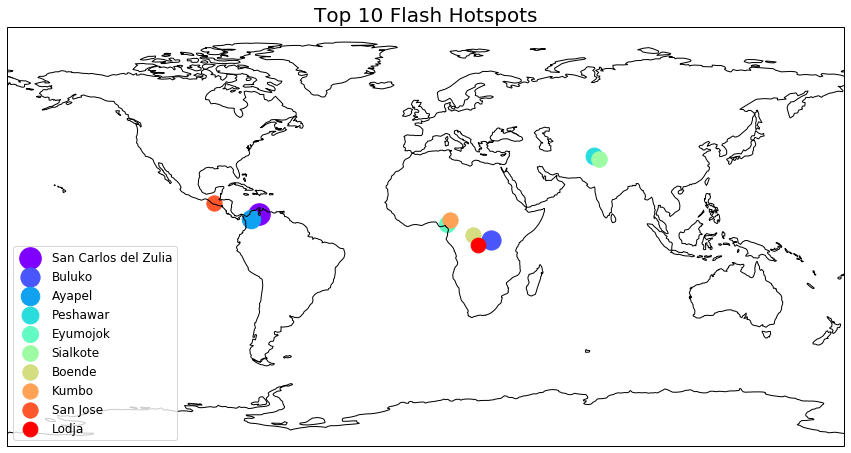

In [13]:
import matplotlib.cm as cm

plt.close('all')

f = plt.figure(figsize=(15,10)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180,-90, 90])
ax.coastlines()

colors = cm.rainbow(np.linspace(0, 1, 10))

for x, y, size, name, i in zip(top10.Longitude, top10.Latitude, top10.VHRFC_LIS_FRD*2, top10.name, range(10)):
        ax.scatter(x, y, s=size, label=name, color=colors[i])
ax.legend(fontsize='large', loc='lower left')

plt.title('Top 10 Flash Hotspots', fontsize = 20) 

plt.savefig('Top 10 Hotspots on map.png')

plt.show()    

### Brief time series analysis for the top 10 hotspots

based on the diurnal (hourly) and monthly climatology datasets

In [14]:
#hourly flash rates
frd_h = Dataset(file_path + 'VHRDC.nc', 'r').variables['VHRDC_LIS_FRD'][:].data
frd_h.shape

(24, 760, 3600)

In [15]:
#monthly flash rates
frd_m = Dataset(file_path + 'VHRMC.nc', 'r').variables['VHRMC_LIS_FRD'][:].data
frd_m.shape

(12, 760, 3600)

In [16]:
#find the corresponding gridded lats and lons
top10['grid_Lon'] = round((top10.Longitude + 180)*10)
top10['grid_Lat'] = round((top10.Latitude  + 38)*10)


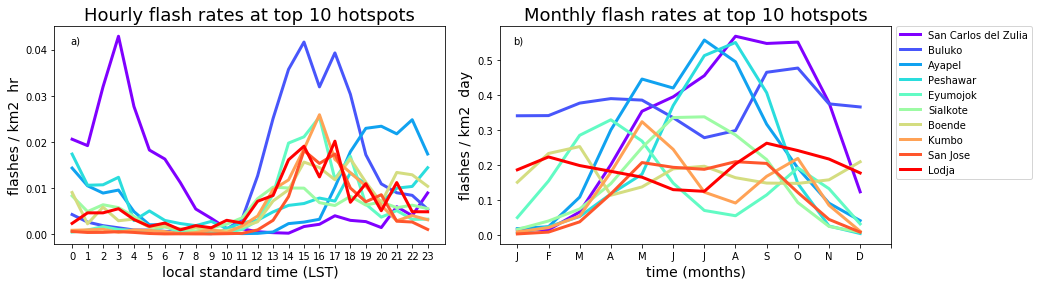

In [17]:
plt.close('all')

f = plt.figure(figsize=(15,4))
colors = cm.rainbow(np.linspace(0, 1, 10))

ax = f.add_subplot(121)
for i in range(10):
    a = frd_h[:, int(top10.grid_Lat.iloc[i]),int(top10.grid_Lon.iloc[i])]
    ax.plot(a, linewidth=3, c=colors[i])
ax.set_xticks(np.arange(0, 24, 1.0))
ax.set_xlabel("local standard time (LST)",  fontsize=14)
ax.set_ylabel('flashes / km2  hr', fontsize=14)
plt.figtext(0.14, 0.82, 'a)')
plt.title('Hourly flash rates at top 10 hotspots', fontsize=18)


ax = f.add_subplot(122)
for i in range(10):
    a = frd_m[:, int(top10.grid_Lat.iloc[i]),int(top10.grid_Lon.iloc[i])]
    ax.plot(a, linewidth=3, c=colors[i], label=top10.name.iloc[i])
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_xlabel("time (months)", fontsize=14)
ax.set_ylabel('flashes / km2  day', fontsize=14)
plt.figtext(0.55, 0.82, 'b)')
plt.title('Monthly flash rates at top 10 hotspots', fontsize=18)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.65))

plt.subplots_adjust(wspace=0.14)

plt.savefig('Brief time series for hotspots.png', bbox_inches = 'tight')

plt.show()